## Projekt "Kaufen oder Warten"
Die Situation kennen alle, die ab und zu Flugtickets kaufen: Sollte man besser warten, weil der Preis vielleicht noch fällt, oder sollte man kaufen? Insbesondere bei der Fluggesellschaft, um die es in diesem Projekt geht, sind scheinbar erratische Preisveränderungen bekannt. Die übliche Regel "je früher, desto besser" ist hier oft nicht die beste Empfehlung.

## Datenbeschreibung
Der Datensatz train_set.csv enthält Preisanfragen zu bestimmten Zeitpunkten für Flüge. Es werden nur zwei verschiedene Strecken in beiden Richtungen betrachtet: zwischen London Stansted und Berlin Schönefeld sowie zwischen London Stansted und Frankfurt.

Die folgenden Merkmale sind enthalten:

Request_Date: Datum und Uhrzeit der Preisanfrage
Flight_Date: Datum des Flugs
Departure_hour: Gerundete Abflugszeit
flight_unique_id: Eindeutige ID für den Flug
route_abb: Abkürzung der Flugroute
Price_In_Eur: Flugpreis
min_future_price_in_Eur: Minimaler Flugpreis für die flight_unique_id über alle zukünftigen Request_Dates
buy: 1 = kaufen, 0 = warten (vorherzusagende Klasse)
Die buy-Klasse wird wie folgt berechnet: if Price_In_Eur - min_future_price_in_Eur <= 0 then 1 else 0

## Aufgabe
Sie sollen ein Modell für eine Kaufempfehlung aus den Daten lernen. Interpretieren Sie ein Zeile in dem Datensatz als eine Preisabfrage, die Sie als Kunde durchführen. Das zu lernende Modell soll Ihnen dann empfehlen, zu dem Preis zu kaufen oder besser zu warten.

Für den ersten Teil der Arbeit überlegen Sie sich, wie Sie solch ein Modell in der Praxis gestalten und anwenden würden. Versetzen Sie sich dazu in die Lage eines Kunden und/oder in die Lage eines Unternehmens. Was könnte bei letzterem das Geschäftsmodell sein?

Welchen Einfluss haben diese Überlegungen auf das Konzept des zu lernenden Modells?

Halten Sie sich beim Vorgehen bitte an die allgemeinen Schritte, die ich oben für alle Projekte beschrieben habe.

## Modellgüte
Benutzen Sie zunächst einfache Vorhersagegenauigkeit zur Beurteilung der Modellgüte (Accuracy). Messen Sie also die Anzahl der richtigen Entscheidungen (Kaufen oder Warten) durch die Anzahl aller Entscheidungen.

Überlegen Sie dann, wie man aus Sicht eines Kunden bzw. Ihres Geschäftsmodells die Güte der Kaufempfehlungen messen sollte. Hier spielen sicher monetäre Überlegungen und Kundenzufriedenheit eine größere Rolle als nur möglichst genaue Empfehlungen. Denken Sie hierbei auch daran, dass man sich als Kunde nicht dem Stress aussetzen möchte, ständig Preise abzufragen.

Sie werden Ihre Ideen bei der Zwischenpräsentation vorstellen und diskutieren. Sie haben dann die Gelegenheit, für den zweiten Teil der Arbeit (Bauen der Modelle) Ihre Überlegungen basierend auf den Diskussionen anzupassen und auch Ideen von anderen Gruppen aufzunehmen.

## Wettbewerb
Es gibt einen Testdatensatz (s.u.), der dasselbe Datenformat wie der Trainingsdatensatz aufweist - nur die Spalten min_future_price_in_Eur und buy fehlen, da diese in der Anwendungssituation nicht bekannt wären. Für die Abgabe der Arbeit sollen Sie Ihre Modelle auf den Testdatensatz anwenden und das Ergebnis mit abgeben (Beschreibung siehe beim Abgabetermin weiter oben in Moodle). Wir werden die besten Modelle als Sieger küren, wenn alle Gruppen abgegeben haben.

Dazu werden wir zwei verschiedene Gütemaße betrachten: die einfache Genauigkeit (Accuracy) und das monetäre Gütemaß, auf das wir uns noch einigen werden.

In [71]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import matplotlib.patches as mpatches
sns.set_theme(style="whitegrid")
import matplotlib.cm as cm
from datetime import datetime
from dateutil import tz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

In [72]:
# Trainingsdaten in einer Dataframme einlesen
flug_df = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/train_set.csv")
# Die fünf ersten Objekte ausgeben
flug_df.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


In [3]:
# Trestdaten in einer Dataframme einlesen
flug_df_test = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/test_set.csv")
# Die fünf letzten Objekte ausgeben
print(flug_df_test.tail())

# Prüfen, ob Merkmale in Training vorhanden sind, die in Testdaten fehlen
print(f"\nFolgende Merkmale fehlen in Testdaten: {set(flug_df) - set(flug_df_test)}")


      index          Request_Date Flight_Date  Departure_hour  \
5578   5579  2019-07-30T23:00:00Z  2019-08-02              22   
5579   5580  2019-07-31T11:00:00Z  2019-08-02              22   
5580   5581  2019-07-31T23:00:00Z  2019-08-02              22   
5581   5582  2019-08-01T11:00:00Z  2019-08-02              22   
5582   5583  2019-08-01T23:00:00Z  2019-08-02              22   

        flight_unique_id route_abb  Price_In_Eur  
5578  2019-08-02 FR 8545   SXF-STN         42.83  
5579  2019-08-02 FR 8545   SXF-STN         50.99  
5580  2019-08-02 FR 8545   SXF-STN         50.99  
5581  2019-08-02 FR 8545   SXF-STN         50.99  
5582  2019-08-02 FR 8545   SXF-STN         50.99  

Folgende Merkmale fehlen in Testdaten: {'buy', 'min_future_price_in_Eur'}


# **Deskriptive Datenanalyse**

In [4]:
# Funktion zur Ausgabe von Informationen über den DataFrame einschließlich Indexdatentyps 
#Spalten und Nicht-Null-Werte

def check_data(data, data_type):
    
    print(f"---------------------------------------\nGrundaten über {data_type} Dataset\n---------------------------------------")
    print(f"Anzahl von Datenpunkten: {len(data)}")
    print(f"Anzahl von Merkmalen: {len(data.columns)}\n")
    print(f"Datentypen:\n-----------\n{data.dtypes} \n")
    print(f"Fehlende Werte:\n---------------\n{data.isnull().sum()} \n")
    print(f"Statistiken numerische Werten:\n-------------------------------\n{data.describe().transpose()}")
    print(f"\nStatistiken kategorische Werten:\n-------------------------------\n{data.describe(include='O').transpose()}")
    print(f"\nAnzahl von Duplicates in {data_type}: {len(data.loc[data.duplicated()])}\n")
   

    
check_data(flug_df,'Trainingsdaten')

check_data(flug_df_test,'Testdaten')

---------------------------------------
Grundaten über Trainingsdaten Dataset
---------------------------------------
Anzahl von Datenpunkten: 83624
Anzahl von Merkmalen: 9

Datentypen:
-----------
index                        int64
Request_Date                object
Flight_Date                 object
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
min_future_price_in_Eur    float64
buy                          int64
dtype: object 

Fehlende Werte:
---------------
index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64 

Statistiken numerische Werten:
-------------------------------
                           count          mean           std   min       25%  \
index               

Die Trainingsdaten bestehen aus 8 Features(Spalten)  und 83624 Exemplare (Zeilen). Davon sind 4 Spalten vom Datentyp "object", was mit String gleichzusetzen ist: Request_date, Flight_date, flight_unique_id und route_abb. Die Spalten Departure_hour und buy enthalten ganze Zahlen vom Typ int64 und die Spalten Price_In_Eur und min_future_price_in_Eur gleitkomma Zahlen vom Typ float64.
Die Statistiken zeigen unterschiedliche statischen Werte von Merkmalen. Je nachdem ob der Spalte numerische Werte oder Zeichenfolge enthält wechseln die Parameter ab. Für numerische Werte werden Anzahl(count), durschnittliche Mittelwert(mean), Standardabweichung(std), Minimum(min), Maximum(max) und Percentiles(25%,50% und 75%) berechnet. Für Zeichenfolge werden hingegen Anzahl(count), Anzahl eindeutige Werte(unique), häufigste Wert(top) und wie oft dieser Wert in den Daten vorkommt(freq) berechnet.


##### Nachfolgend werden die Wertebereiche für die numerische Spalten mit Boxplots veranschaulicht 

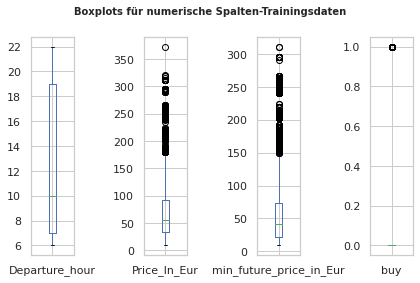

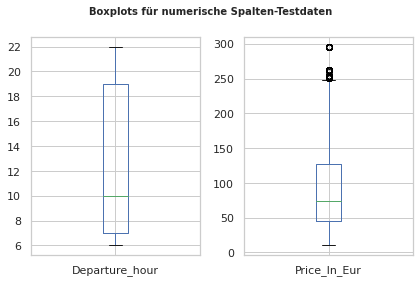

In [5]:

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='bold',
                                   style='normal', size=10)
def Num_Spalten_visuals(dataframe, datentyp):
    
    cols = dataframe.columns
    new_col = []
    for col in cols:
        if (dataframe[col].dtypes == 'int64' or dataframe[col].dtypes == 'float64') and (col != 'index'):
            new_col.append(col)
    dataframe[new_col].plot(subplots=True,kind='box')
    plt.suptitle('Boxplots für numerische Spalten'+ datentyp,fontproperties=font)
    plt.tight_layout()
    plt.show()    

Num_Spalten_visuals(flug_df,'-Trainingsdaten')
Num_Spalten_visuals(flug_df_test,'-Testdaten')



Aus dem obigen Diagramm können wir ableiten, dass dieSpalten "Price_in_Eur" und "min_future_price_in_Eur" Ausreißer enthalten. Die Ausreißer liegen in Trainingsdaten liegen nach dem Wert "150" für min_future_price_in_Eur und nach ca "180" für Price_In_Eur".
Die Abflüge finden von 6 Uhr bis 22 Uhr statt. Für alle Abfragen gilt: Der günstigste Flug kostet 8,99 € und der teuerste 372,96

In [6]:
# Find the 75th and 25th percentiles für Price_In_Eur
price_seventy_fifth = flug_df["Price_In_Eur"].quantile(0.75)
price_twenty_fifth = flug_df["Price_In_Eur"].quantile(0.25)

# Calculate iqr
prices_iqr = price_seventy_fifth - price_twenty_fifth

# Calculate the thresholds
upper = price_seventy_fifth + (1.5 * prices_iqr)
lower = price_twenty_fifth - (1.5 * prices_iqr)

# Subset the data without outliers
flug_df_ohne_Outliers_Price = flug_df[(flug_df["Price_In_Eur"] > lower) & (flug_df["Price_In_Eur"] < upper)]

print(flug_df_ohne_Outliers_Price["Price_In_Eur"].describe())

count    78744.000000
mean        62.318011
std         39.223014
min          8.990000
25%         30.330000
50%         52.510000
75%         85.190000
max        180.210000
Name: Price_In_Eur, dtype: float64


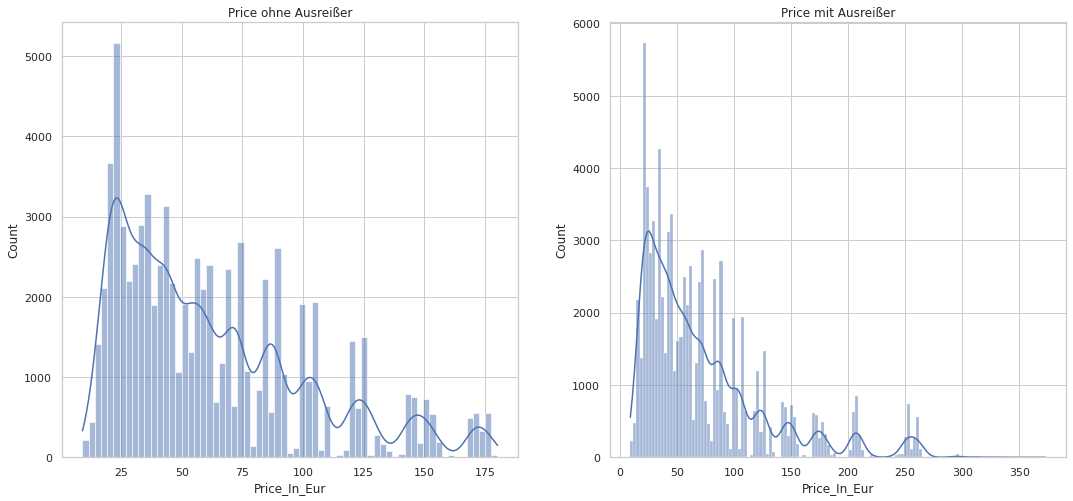

In [7]:
# Datenverteilung "Price_In_Eur" ohne Ausreißer
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.histplot(data=flug_df_ohne_Outliers_Price,x='Price_In_Eur',kde='True',ax=ax[0])
ax[0].set_title('Price ohne Ausreißer')

# Datenverteilung "Price_In_Eur" mit Ausreißer
sns.histplot(data=flug_df,x='Price_In_Eur',kde='True',ax=ax[1])
ax[1].set_title('Price mit Ausreißer')
plt.show()


## Datentypkonvertierung

Wenn wir die Daten, die in den Spalten vorkommen mit ihren Datentypen vergleichen,stellt man fest, dass einige Feautures nicht der richtige Datentyp haben.Zum Beispiel 'Buy' hier ist die vorherzusagende Klasse, deswegen sollte der Feature vom Datentyp 'Category'sein. 
Die Feautures 'Request_Date'und 'Flight_Date' sollten vom Datentyp 'datetime' sein. Der Feature 'Request_Date' ist im UTC-Format gespeichert, Deswegen muss er erstmal in Localen Format umkonvertiert werden.
Der Datentyp des Features 'buy' wird später auch für das Training in den Datentyp 'category' konvertiert, da es sich hierbei um die vorherzusagende Klasse handelt.

In [8]:
def local_time(row):
    if row['route_abb'].split('-')[0] == 'SXF' or row['route_abb'].split('-')[0] == 'FRA':
        # Zeitzone
        zone = "Europe/Berlin"
    else:
        # Zeitzone
        zone = "Europe/London"
    
    # Konvertierung in ein datetime-Objekt
    dtUTC = datetime.strptime(row['Request_Date'], '%Y-%m-%dT%H:%M:%SZ')
    dtZone = dtUTC.replace(tzinfo=tz.gettz('UTC')).astimezone(tz.gettz(zone))
    
    # Formatierung des DateTime-Strings ohne Zeitzonen-Offset-Information
    dtString = dtZone.strftime('%Y-%m-%d %H:%M:%S')
    
    # Rückgabe des konvertierten Werts
    return pd.to_datetime(dtString)

# Konvertierung Trainingsdaten
flug_df['Request_Date'] = flug_df.apply( local_time, axis=1)
#flug_df['buy']= flug_df['buy'].astype('category')
flug_df['Flight_Date']= pd.to_datetime(flug_df['Flight_Date']) 

# Konvertierung Trainingsdaten
flug_df_test['Request_Date'] = flug_df_test.apply( local_time, axis=1) 
flug_df_test['Flight_Date']= pd.to_datetime(flug_df['Flight_Date'])
   
print(f"Datentyp von Features nach Konvertierung: Trainingsdaten\n\n{flug_df.dtypes}")
print(f"\nDatentyp von Features nach Konvertierung: Testdaten\n\n{flug_df_test.dtypes}")

Datentyp von Features nach Konvertierung: Trainingsdaten

index                               int64
Request_Date               datetime64[ns]
Flight_Date                datetime64[ns]
Departure_hour                      int64
flight_unique_id                   object
route_abb                          object
Price_In_Eur                      float64
min_future_price_in_Eur           float64
buy                                 int64
dtype: object

Datentyp von Features nach Konvertierung: Testdaten

index                        int64
Request_Date        datetime64[ns]
Flight_Date         datetime64[ns]
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
dtype: object


## Korrelationen

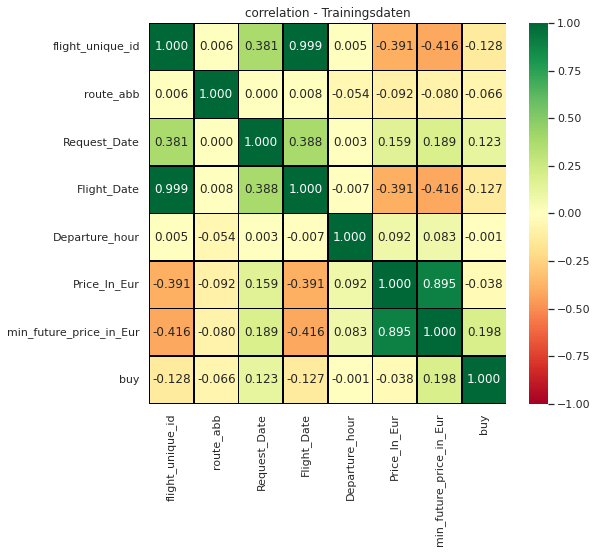

In [9]:
colcat = ['flight_unique_id', 'route_abb','Request_Date','Flight_Date']
colnum = ['Departure_hour','Price_In_Eur','min_future_price_in_Eur','buy']

#Erstellung numerischer Darstellungen von kategorialen Variablen in Trainingsdaten
df = flug_df[colcat].apply(lambda x : pd.factorize(x)[0])
df_concat = pd.concat([df,flug_df[colnum]], axis=1) 

# Berechnung der Korrelationsmatrix
corrmat=df_concat.corr(method='pearson')

# Visualisierung der Koorelationsmatrix
plt.figure(figsize=(8,7))
sns.heatmap(corrmat, annot=True,
            fmt='.3f',
            linecolor='black', linewidths=.5,
            cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('correlation - Trainingsdaten')
plt.show()

Die Korrelation zeigt, dass die beiden Merkmale 'Buy' und 'min_future_price_in_Eur' korreliert sind und ein proportionalen Verhältnis aufweisen. Wenn der Wert von 'Buy' steigt, steigt auch der Wert von 'min_future_price_in_Eur'.

## Explorative Analyse

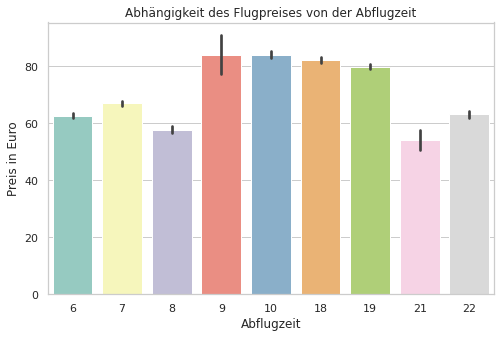

In [10]:
# Abhängigkeit des Flugpreises von der Abflugzeit
plt.figure(figsize=(8,5))
sns.barplot(data=flug_df, x='Departure_hour',y='Price_In_Eur', palette='Set3')
plt.title('Abhängigkeit des Flugpreises von der Abflugzeit')
plt.xlabel('Abflugzeit')
plt.ylabel('Preis in Euro')
plt.show()

<Figure size 576x360 with 0 Axes>

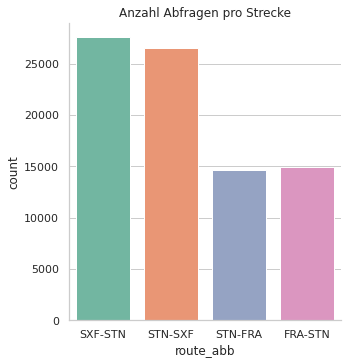

In [11]:
# Welche Strecken werden am meisten abgefragt?
plt.figure(figsize=(8,5))
sns.catplot(x='route_abb', data=flug_df, kind='count', palette='Set2')
plt.title('Anzahl Abfragen pro Strecke')
plt.show()

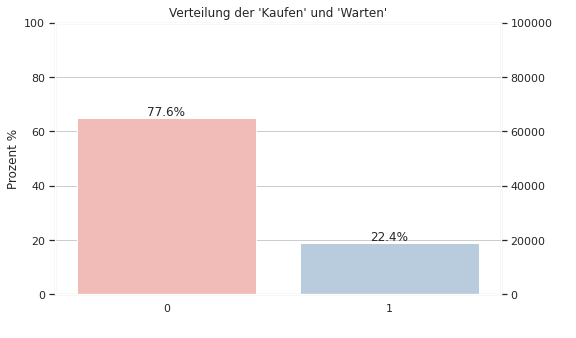

In [12]:
def default():
    ncount = len(flug_df)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Prozent %')
    plt.title("Verteilung der 'Kaufen' und 'Warten'")

    for i in ax.patches:
        x=i.get_bbox().get_points()[:,0]
        y=i.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

ax = sns.countplot(x=flug_df.buy, palette="Pastel1")
sns.set(font_scale=1.)
ax.set_ylim(top=100000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,5)
ax.set_ylim(top=100000)

default()

plt.show()


Dadurch stellt man fest das der Datensatz unbalanciert ist. Wir haben  64906 warten und nur 18718 kaufen. Was uns schon der Hinweis gibt dass, beim Aufteilen der Trainingdaten Stratifizierung verwenden sollten.

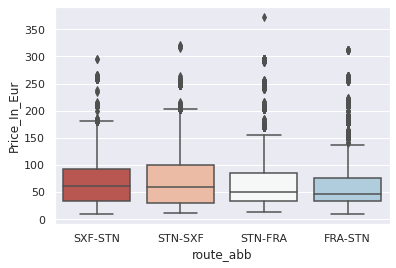

Der Mittelpreis liegt bei 74.79 wenn man der Preis von Berlin nach London abfragt
Der Mittelpreis liegt bei 77.38 wenn man der Preis von London nach Berlin  abfragt
Der Mittelpreis liegt bei 67.57 wenn man der Preis von London nach Frankfurt  abfragt
Der Mittelpreis liegt bei 61.45 wenn man der Preis von Frankfurt nach London abfragt


In [13]:
# wie teuer sind die Flüge auf die unterschiedlichen Strecken?
sns.boxplot(x = 'route_abb', y =flug_df['Price_In_Eur'], data = flug_df, palette = sns.color_palette('RdBu',5))
plt.show()
route_SXF_STN = flug_df.loc[flug_df['route_abb'] =='SXF-STN', 'Price_In_Eur']
route_STN_SXF= flug_df.loc[flug_df['route_abb'] =='STN-SXF', 'Price_In_Eur']
route_STN_FRA = flug_df.loc[flug_df['route_abb'] =='STN-FRA', 'Price_In_Eur']
route_FRA_STN = flug_df.loc[flug_df['route_abb'] =='FRA-STN', 'Price_In_Eur']
print("Der Mittelpreis liegt bei {}".format(round(route_SXF_STN.mean(), 2)), "wenn man der Preis von Berlin nach London abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_SXF.mean(), 2)), "wenn man der Preis von London nach Berlin  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_FRA.mean(), 2)), "wenn man der Preis von London nach Frankfurt  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_FRA_STN.mean(), 2)), "wenn man der Preis von Frankfurt nach London abfragt")

Das würde bedeuten es ist güngstiger in Richtung London der Flugticket von Frankfurt zu buchen und für die Rückreise nach Deutschland ist es auch günstiger in Frankfurt zu landen.

In [14]:
# Anzahl Flüge für eine Strecke an einem bestimmten Tag
f=flug_df.groupby(['Flight_Date','route_abb']).nunique()['flight_unique_id']
print(f.reset_index())
print(f'Die maximale Anzahl von Flüge an einem bestimmten Tag über eine Strecke ist {max(f.reset_index().flight_unique_id)}')


    Flight_Date route_abb  flight_unique_id
0    2019-06-05   STN-SXF                 1
1    2019-06-05   SXF-STN                 2
2    2019-06-06   STN-FRA                 1
3    2019-06-06   STN-SXF                 3
4    2019-06-06   SXF-STN                 4
..          ...       ...               ...
380  2019-09-09   STN-FRA                 2
381  2019-09-09   STN-SXF                 4
382  2019-09-09   SXF-STN                 4
383  2019-09-10   STN-SXF                 2
384  2019-09-10   SXF-STN                 2

[385 rows x 3 columns]
Die maximale Anzahl von Flüge an einem bestimmten Tag über eine Strecke ist 4


## Feature ingeneering

Basierend auf die vorhandenen Merkmalen können weitere abgeleitete Merkmale definiert werden:

- days_diff_Req_Flight: Zeitdauer bis zum Flug in Tagen (berechnet als Flight_Date - Request_Date)
- DayofWeek: Wochentag des Flugs und der Abfrage (0 bis 6)
- Month: Monat des Flugs und der Abfrage (1 bis 12)
- weekofyear: Kalenderwoche des Flugs
- Feiertage: Ein binäres Merkmal , das angibt, ob der Flug an einem Feiertag stattfindet.
- Saison: Ein Merkmal, das die Saison des Jahres (Frühling, Sommer, Herbst, Winter) basierend auf dem Flugdatum angibt.
- Departure_time und Request_time: als Umrechnung jeweils des Abflugszeit und Abfragezeit in Tageszeiten
- Source und Destination: als Zerlegung der Strecke in Start- und Endpunkt
- Price_in_eur_max,-min, und -mean: als maximaler, minimaler und mittlerer Preis für einen Flug auf eine bestimmte Strecke
- Number_of_request: als Anzahl von Abfrage je Flug



In [15]:
def generate_features(dataframe):
    #eine Reihe von Merkmalen unter Verwendung der Datumsspalten erstellen
    dataframe.loc[:,'Request_Dayofweek'] = dataframe['Request_Date'].dt.dayofweek
    dataframe.loc[:,'Request_month'] = dataframe['Request_Date'].dt.month
    dataframe.loc[:,'days_diff_Req_Flight'] = (pd.to_datetime(dataframe['Flight_Date'])- pd.to_datetime(dataframe['Request_Date'])).dt.days
    dataframe.loc[:,'Flight_Dayofweek'] = dataframe['Flight_Date'].dt.dayofweek
    dataframe.loc[:,'Flight_month'] = dataframe['Flight_Date'].dt.month
    dataframe.loc[:,'Flight_weekofyear'] = dataframe['Flight_Date'].dt.isocalendar().week
    dataframe.loc[:,'weekend']= (dataframe['Flight_Date'].dt.weekday >=5).astype(int)
    
    # Umrechnung der Departure_hour in Vormittag/Nachmittag/Abend usw.
    s = (dataframe["Departure_hour"] % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
    # Werte ersetzen 1:latenight to 6: night
    s.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) 
    dataframe["departure_time"] = s
    
    # Umrechnung der Request_Time in Vormittag/Nachmittag/Abend usw.
    t = (dataframe['Request_Date'].dt.hour % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
    # Werte ersetzen 1:latenight to 6: night
    t.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) 
    dataframe["Request_time"] = t
  

    #Die Merkmales source und destination aus dem Spalten route_abb erstellen
    
      
    dataframe['source'] =''
    dataframe['destination'] =''
    unique_routes = dataframe['route_abb'].unique()
    for route in unique_routes:
        if route == 'SXF-STN':
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Berlin'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
        elif route == 'STN-SXF':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Berlin'
        elif route == 'STN-FRA':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Frankfurt'
        elif route == 'FRA-STN':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Frankfurt'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
    return dataframe

In [16]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start=year+'-03-21', end=year+'-06-20'),#Frühling
               'summer': pd.date_range(start=year+'-06-21', end=year+'-09-22'),#Sommer
               'autumn': pd.date_range(start=year+'-09-23', end=year+'-12-20')}#Herbst
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


# Jahreszeit extrahieren aus Trainingsdaten
flug_df['season'] = flug_df['Flight_Date'].apply(season_of_date)

# Jahreszeit extrahieren aus Testdaten
flug_df_test['season'] = flug_df_test['Flight_Date'].apply(season_of_date)

In [17]:
# einen aggregierten Datenrahmen erstellen, um die Informationen über die Preise für die Kombination Flug+route zu erhalten

def agg_Dataframe(df):

 # ein aggregate dictionary erstellen
    aggs = {}
 
 # nach Price_In_Eur und die Aggregate  max, min and mean für den Merkmal berechnen
    aggs['Price_In_Eur'] = ['max','min','mean']
 # nach Request_date und das aggregat size berechnen 
    aggs['Request_Date'] = ['size']  
    
 # nach flight_unique_id und route_abb gruppieren und die Aggregate berechnen
    agg_df = df.groupby(['flight_unique_id','route_abb']).agg(aggs)

 # die Spaltennamen abflachen
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    
 # index zurücksetzen
    agg_df = agg_df.reset_index()

 # aggregierte Dataframe zurückgeben    
    return agg_df

In [18]:
#Dataframe Trainingsdaten aggregieren
flug_df_agg = agg_Dataframe(flug_df)

#Dataframe Testdaten aggregieren
flug_df_test_agg = agg_Dataframe(flug_df_test)

# einige Spaltennemen entsprechend umbenennen
flug_df_agg = flug_df_agg.rename(columns={'Request_Date_size': 'Number_of_Request', 'flight_unique_id_nunique': 
                                          'Number_of_Flight'})

flug_df_test_agg = flug_df_test_agg.rename(columns={'Request_Date_size': 'Number_of_Request', 'flight_unique_id_nunique': 
                                          'Number_of_Flight'})


In [19]:
# aggregierte Trainingsdaten
flug_df_agg

,flight_unique_id,route_abb,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-06-05 FR 146,SXF-STN,259.07,208.07,246.320000,4
1,2019-06-05 FR 147,STN-SXF,252.06,143.86,224.840000,4
2,2019-06-05 FR 8545,SXF-STN,50.99,22.17,30.970000,4
3,2019-06-06 FR 144,SXF-STN,73.43,61.19,67.310000,4
4,2019-06-06 FR 146,SXF-STN,259.07,149.93,220.922000,5
...,...,...,...,...,...,...
1002,2019-09-09 FR 8545,SXF-STN,92.73,19.99,48.729508,122
1003,2019-09-10 FR 144,SXF-STN,50.99,9.99,21.242439,123
1004,2019-09-10 FR 145,STN-SXF,35.13,11.21,22.158049,123
1005,2019-09-10 FR 8542,STN-SXF,24.64,11.21,18.900325,123


In [20]:
# aggregierte Testingsdaten
flug_df_test_agg

,flight_unique_id,route_abb,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-07-02 FR 145,STN-SXF,253.20,24.72,73.101481,54
1,2019-07-02 FR 1546,FRA-STN,262.13,30.33,95.370816,49
2,2019-07-03 FR 8545,SXF-STN,262.13,14.99,77.175932,59
3,2019-07-04 FR 8544,STN-SXF,253.20,41.97,102.393559,59
4,2019-07-05 FR 8542,STN-SXF,253.20,30.16,93.090484,62
...,...,...,...,...,...,...
60,2019-08-02 FR 146,SXF-STN,262.13,19.99,66.072393,117
61,2019-08-02 FR 147,STN-SXF,254.01,58.65,148.543739,115
62,2019-08-02 FR 1686,FRA-STN,219.29,33.65,65.054103,117
63,2019-08-02 FR 1687,STN-FRA,176.20,34.89,82.595391,115


In [21]:
# Trainingsdaten/Testdaten und aggregierte Dataframe verknüpfen

Trainingsdaten = generate_features(flug_df).merge(flug_df_agg)
Testdaten =  generate_features(flug_df_test).merge(flug_df_test_agg)

In [22]:
# Merkmale Index und Merkmale löschen,die zur Erstellung neuer Merkmalen verwendet wurden,um Multikollinearität zu vermeiden

Trainingsdaten.drop(columns=['index','Flight_Date','Departure_hour','route_abb'],axis=1,inplace=True)


Testdaten.drop(columns=['index','Flight_Date','Departure_hour','route_abb'],axis=1,inplace=True)

In [23]:
Trainingsdaten

,Request_Date,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,season,Request_Dayofweek,Request_month,days_diff_Req_Flight,Flight_Dayofweek,Flight_month,Flight_weekofyear,weekend,departure_time,Request_time,source,destination,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-06-03 13:00:00,2019-06-05 FR 146,208.07,259.07,1,spring,0,6,1,2,6,23,0,Evening,Afternoon,Berlin,London,259.07,208.07,246.320000,4
1,2019-06-04 01:00:00,2019-06-05 FR 146,259.07,259.07,1,spring,1,6,0,2,6,23,0,Evening,Late Night,Berlin,London,259.07,208.07,246.320000,4
2,2019-06-04 13:00:00,2019-06-05 FR 146,259.07,259.07,1,spring,1,6,0,2,6,23,0,Evening,Afternoon,Berlin,London,259.07,208.07,246.320000,4
3,2019-06-05 01:00:00,2019-06-05 FR 146,259.07,259.07,1,spring,2,6,-1,2,6,23,0,Evening,Late Night,Berlin,London,259.07,208.07,246.320000,4
4,2019-06-03 12:00:00,2019-06-05 FR 147,143.86,251.72,1,spring,0,6,1,2,6,23,0,Night,Afternoon,London,Berlin,252.06,143.86,224.840000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83619,2019-08-01 13:00:00,2019-09-10 FR 8543,35.69,39.69,1,summer,3,8,39,1,9,37,0,Morning,Afternoon,Berlin,London,54.99,9.99,25.745041,123
83620,2019-08-02 01:00:00,2019-09-10 FR 8543,46.83,39.69,0,summer,4,8,38,1,9,37,0,Morning,Late Night,Berlin,London,54.99,9.99,25.745041,123
83621,2019-08-02 13:00:00,2019-09-10 FR 8543,46.83,39.69,0,summer,4,8,38,1,9,37,0,Morning,Afternoon,Berlin,London,54.99,9.99,25.745041,123
83622,2019-08-03 01:00:00,2019-09-10 FR 8543,39.69,39.69,1,summer,5,8,37,1,9,37,0,Morning,Late Night,Berlin,London,54.99,9.99,25.745041,123


### Visualisierung zwischen Features und Zielvariable "buy"

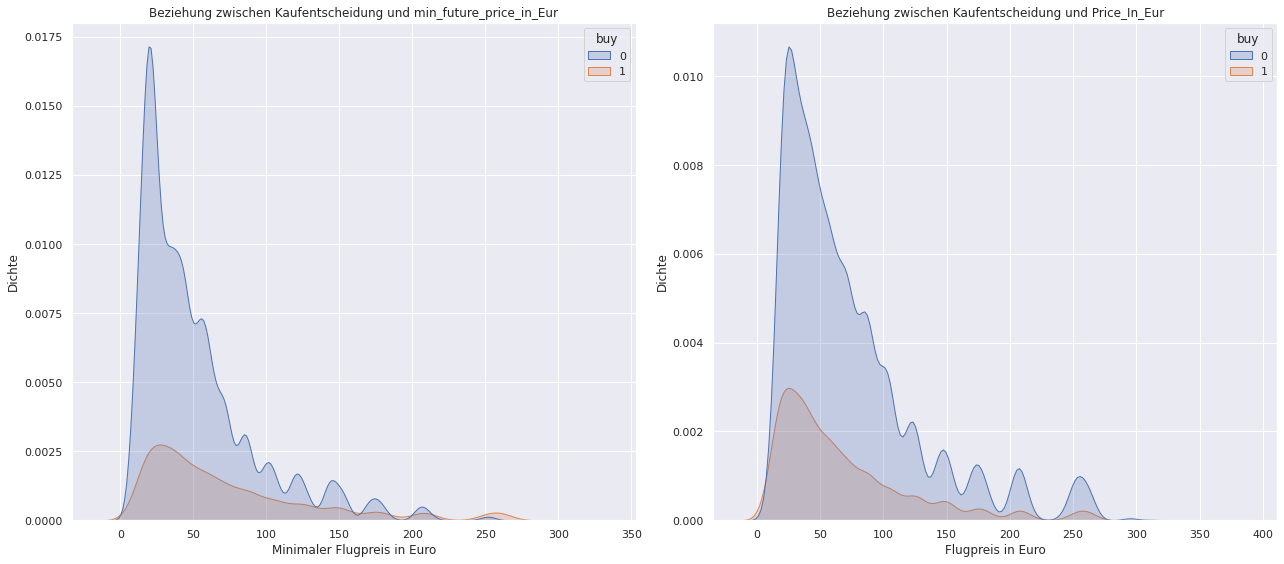

In [24]:
plt.figure(figsize=(18, 8))

# Diagramm für 'min_future_price_in_Eur'
plt.subplot(1, 2, 1)
sns.kdeplot(data=Trainingsdaten, x="min_future_price_in_Eur", hue="buy", fill=True)
plt.title('Beziehung zwischen Kaufentscheidung und min_future_price_in_Eur')
plt.ylabel('Dichte')
plt.xlabel('Minimaler Flugpreis in Euro')

# Diagramm für 'Price_In_Eur'
plt.subplot(1, 2, 2)
sns.kdeplot(data=Trainingsdaten, x="Price_In_Eur", hue="buy", fill=True)
plt.title('Beziehung zwischen Kaufentscheidung und Price_In_Eur')
plt.ylabel('Dichte')
plt.xlabel('Flugpreis in Euro')

plt.tight_layout()
plt.show()


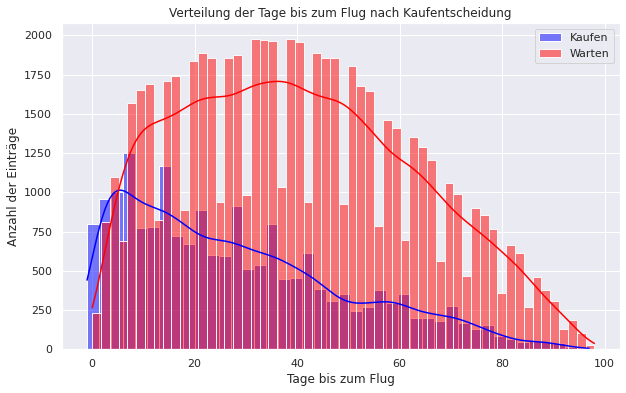

In [25]:
plt.figure(figsize=(10, 6))

# Verteilung der Tage bis zum Flug für die Kategorie 'Kaufen'
sns.histplot(Trainingsdaten[Trainingsdaten['buy'] == 1]['days_diff_Req_Flight'], kde=True, color= 'blue', label='Kaufen')

# Verteilung der Tage bis zum Flug für die Kategorie 'Warten'
sns.histplot(Trainingsdaten[Trainingsdaten['buy'] == 0]['days_diff_Req_Flight'], kde=True, color='red', label='Warten')

plt.title('Verteilung der Tage bis zum Flug nach Kaufentscheidung')
plt.xlabel('Tage bis zum Flug')
plt.ylabel('Anzahl der Einträge')
plt.legend()
plt.show()


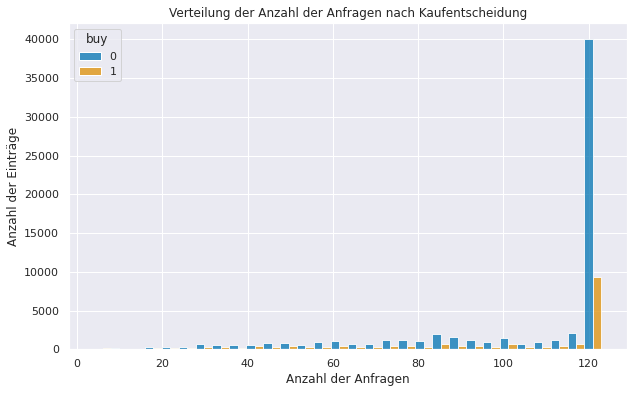

In [26]:
Trainingsdaten['Number_of_Request'] = Trainingsdaten.groupby('flight_unique_id')['flight_unique_id'].transform('count')

plt.figure(figsize=(10, 6))
sns.histplot(data=Trainingsdaten, x='Number_of_Request', hue='buy', bins=30, multiple="dodge", palette='colorblind')

plt.title('Verteilung der Anzahl der Anfragen nach Kaufentscheidung')
plt.xlabel('Anzahl der Anfragen')
plt.ylabel('Anzahl der Einträge')
plt.show()




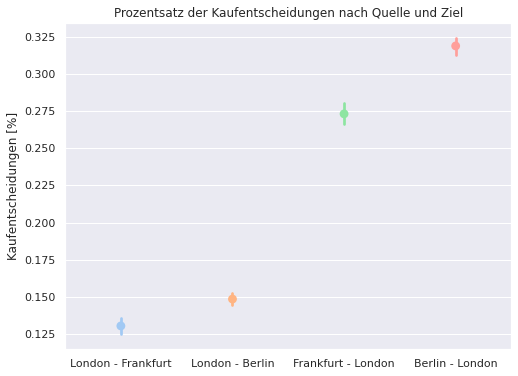

In [27]:
plt.figure(figsize=(8, 6))

Trainingsdaten['source_destination'] = Trainingsdaten['source'] + ' - ' + Trainingsdaten['destination']


source_destination_buy_percentage = Trainingsdaten.groupby('source_destination')['buy'].mean() * 100
sorted_source_destination = source_destination_buy_percentage.sort_values().index

sns.pointplot(data=Trainingsdaten, x='source_destination', y='buy', order=sorted_source_destination, join=False, palette='pastel')
plt.title('Prozentsatz der Kaufentscheidungen nach Quelle und Ziel')
plt.ylabel('Kaufentscheidungen [%]')
plt.xlabel('') 
plt.show()

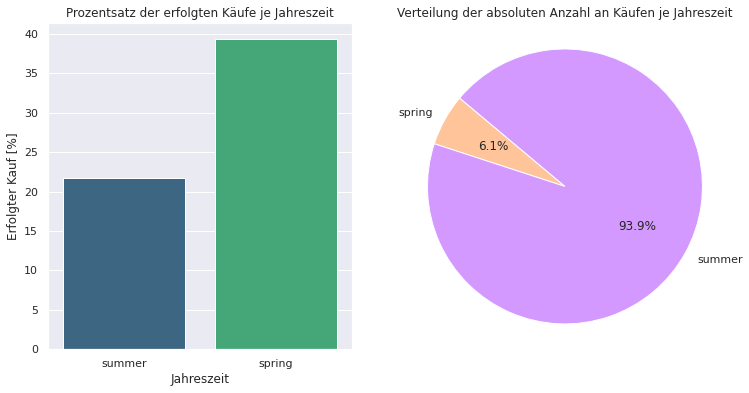

In [28]:
# Berechnungen für die Diagramme
buy_percentage_by_season = Trainingsdaten.groupby('season')['buy'].mean() * 100
sorted_seasons = buy_percentage_by_season.sort_values().index
buy_counts_by_season = Trainingsdaten.groupby('season')['buy'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Barplot
sns.barplot(x=sorted_seasons, y=buy_percentage_by_season[sorted_seasons], palette='viridis', ax=ax[0])
ax[0].set_title('Prozentsatz der erfolgten Käufe je Jahreszeit')
ax[0].set_ylabel('Erfolgter Kauf [%]')
ax[0].set_xlabel('Jahreszeit')

# Pie Chart
colors = ['#ffc499','#d499ff'] 
ax[1].pie(buy_counts_by_season, labels=buy_counts_by_season.index, autopct='%1.1f%%', startangle=140, colors=colors)
ax[1].axis('equal') 
ax[1].set_title('Verteilung der absoluten Anzahl an Käufen je Jahreszeit')

plt.show()


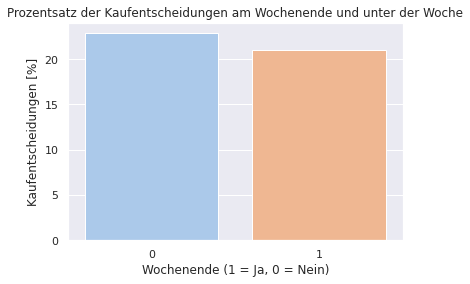

In [29]:
# Berechnung des Prozentsatzes der Kaufentscheidungen für jede Kategorie der 'weekend'-Variable
weekend_buy_percentage = Trainingsdaten.groupby('weekend')['buy'].mean() * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=weekend_buy_percentage.index, y=weekend_buy_percentage, palette='pastel')
plt.title('Prozentsatz der Kaufentscheidungen am Wochenende und unter der Woche')
plt.ylabel('Kaufentscheidungen [%]')
plt.xlabel('Wochenende (1 = Ja, 0 = Nein)')
plt.show()

In [30]:
Testdaten

,Request_Date,flight_unique_id,Price_In_Eur,season,Request_Dayofweek,Request_month,days_diff_Req_Flight,Flight_Dayofweek,Flight_month,Flight_weekofyear,weekend,departure_time,Request_time,source,destination,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-06-03 12:00:00,2019-07-02 FR 145,30.32,spring,0,6,1,2,6,23,0,Early Morning,Afternoon,London,Berlin,253.20,24.72,73.101481,54
1,2019-06-04 00:00:00,2019-07-02 FR 145,44.53,spring,1,6,1,2,6,23,0,Early Morning,Late Night,London,Berlin,253.20,24.72,73.101481,54
2,2019-06-04 12:00:00,2019-07-02 FR 145,44.47,spring,1,6,0,2,6,23,0,Early Morning,Afternoon,London,Berlin,253.20,24.72,73.101481,54
3,2019-06-05 00:00:00,2019-07-02 FR 145,44.47,spring,2,6,0,2,6,23,0,Early Morning,Late Night,London,Berlin,253.20,24.72,73.101481,54
4,2019-06-05 12:00:00,2019-07-02 FR 145,44.52,spring,2,6,-1,2,6,23,0,Early Morning,Afternoon,London,Berlin,253.20,24.72,73.101481,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,2019-07-31 01:00:00,2019-08-02 FR 8545,42.83,summer,2,7,-35,3,6,26,0,Night,Late Night,Berlin,London,50.99,17.99,29.006581,117
5579,2019-07-31 13:00:00,2019-08-02 FR 8545,50.99,summer,2,7,-35,3,6,26,0,Night,Afternoon,Berlin,London,50.99,17.99,29.006581,117
5580,2019-08-01 01:00:00,2019-08-02 FR 8545,50.99,summer,3,8,-36,3,6,26,0,Night,Late Night,Berlin,London,50.99,17.99,29.006581,117
5581,2019-08-01 13:00:00,2019-08-02 FR 8545,50.99,summer,3,8,-36,3,6,26,0,Night,Afternoon,Berlin,London,50.99,17.99,29.006581,117


### Daten trennen in Features und Zielvariablen (mit Ausreißer im Spalten Price_in_Eur)


In [31]:
 Feature = [ 'Price_In_Eur',
       'season', 'Request_Dayofweek', 'Request_month', 'days_diff_Req_Flight',
       'Flight_Dayofweek', 'Flight_month', 'Flight_weekofyear', 'weekend',
       'departure_time', 'Request_time', 'source', 'destination',
       'Price_In_Eur_max', 'Price_In_Eur_min', 'Price_In_Eur_mean',
       'Number_of_Request']
    
def get_X_y(Trainingsdaten):
    X = Trainingsdaten[Feature]
    y = Trainingsdaten['buy']
    groups = Trainingsdaten['flight_unique_id']
    return X,y,groups


X_test = Testdaten[Feature]

In [32]:
X,y,Groups = get_X_y(Trainingsdaten)

sgk =StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=529)

def get_train_val_daten(X,y,Groups):
    for train_idx,val_idx in sgk.split(X,y,Groups):
        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]
        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]
    return X_train,y_train,X_val,y_val

X_train,y_train,X_val,y_val = get_train_val_daten(X,y,Groups)


## Feature processing
### Normalisierung von numerischen Merkmalen und binäre Kodierung                                      von nominalen Merkmalen

In [33]:
# Merkmale für numerische Transformation
numeric_features = ['Price_In_Eur','Price_In_Eur_max','Price_In_Eur_min','Price_In_Eur_mean','Number_of_Request',
                   'days_diff_Req_Flight','weekend','Request_Dayofweek','Request_month',
                    'Flight_Dayofweek','Flight_month','Flight_weekofyear']

# Merkmale für kategoriale Transformation
categorical_features = ['season','departure_time','Request_time','source','destination']

# Preprocessing-Schritte für numerische Merkmale
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Preprocessing-Schritte für kategoriale Merkmale
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))])

# ColumnTransformer für die kombinierte Transformation der Merkmale
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



# Transformation der Merkmale im X_train
Xtrain_transformed = preprocessor.fit_transform(X_train)
# Überschriften der transformierten Merkmale erhalten
transformed_feature_names_train = preprocessor.get_feature_names_out()

# Transformation der Merkmale im X_val
Xval_transformed = preprocessor.transform(X_val)
# Überschriften der transformierten Merkmale erhalten
transformed_feature_names_val = preprocessor.get_feature_names_out()

# Transformation der Merkmale im X_test
Xtest_transformed = preprocessor.transform(X_test)
# Überschriften der transformierten Merkmale erhalten
transformed_feature_names_test = preprocessor.get_feature_names_out()


In [34]:
# neue Dataframe für Trainingsdaten mit relevanten Merkmalen
frame_train = pd.DataFrame(Xtrain_transformed,columns=preprocessor.get_feature_names_out())
frame_train.shape

(75395, 21)

In [35]:
# neue Dataframe für Validierungsdaten mit relevanten Merkmalen
frame_val = pd.DataFrame(Xval_transformed,columns=transformed_feature_names_val)
frame_val.shape

(8229, 21)

In [36]:
# neue Dataframe für Testdaten mit relevanten Merkmalen
frame_test = pd.DataFrame(Xtest_transformed,columns=transformed_feature_names_test)
frame_test.shape

(5583, 21)

## Features Selection (Zielvariable= Buy)

In diesem Abschnitt verwenden wir zwei Methoden: SelectKBest und Recursive Feature Elimination. Diese dienen dazu, die wichtigsten Merkmale für das Trainings- und Testmodell zu ermitteln.

- ### Mit Selectkbest 

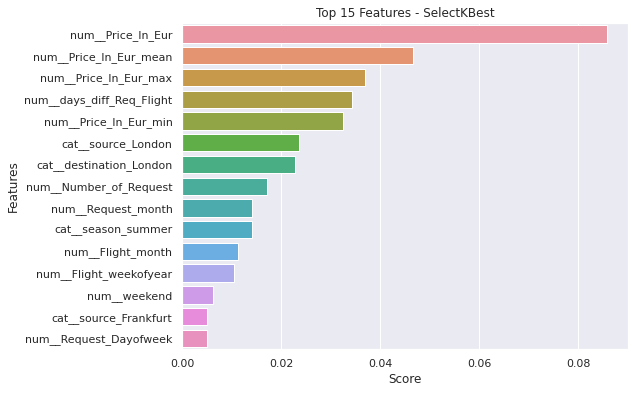

In [37]:
k=15
# SelectKBest-Transformer mit der gewünschten Score-Funktion erstellen
kbest = SelectKBest(score_func= mutual_info_classif, k=k) 

# Transformer auf die Daten anwenden 
Xtrain_selected = kbest.fit_transform(Xtrain_transformed, y_train)

# Die ausgewählten Feature-Indizes erhalten
feature_indices = kbest.get_support(indices=True)

# Die Namen der ausgewählten Features erhalten
selected_features = frame_train.columns[feature_indices]

#Score
feature_scores = kbest.scores_

# Erstelle ein Array mit den Rängen der Features (absteigend sortiert)
top_15_features = np.argsort(feature_scores)[-k::][::-1] 

# Sortiere die Features nach ihrem Score
sorted_scores = np.sort(feature_scores)[-k::][::-1]  
sorted_names = np.array(transformed_feature_names_train)[top_15_features]

# Plotte die Scores der k besten Features
plt.figure(figsize=(8,6))
sns.barplot(x=sorted_scores, y=sorted_names)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title(f'Top {k} Features - SelectKBest')
plt.show()

Daraus können wir sagen, dass die Features "num_Price_In_Eur", "num_Price_In_Eur_mean", "num_Price_In_Eur_max", "num_days_diff_Req_Flight" und "num_Price_in_Eur_min" die Top 5 der wichtigsten Merkmale sind. Diese Merkmale sind größtenteils abgeleitete Features des Merkmals "Price_In_Eur" aus der ursprünglichen CSV-Datei. Die Merkmale "num_Flight_Dayofweek" und "num_weekend" haben dagegen den geringsten Einfluss auf die Zielvariable "buy".

- ### Mit RFECV (Recursive Feature Elimination Cross Validation)

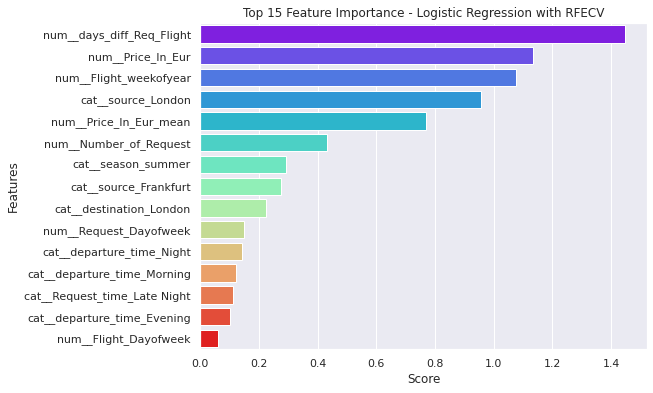

In [38]:
# Erstelle das Basismodell
base_model = LogisticRegression(random_state=42)

# Erstelle RFECV (RFE mit Kreuzvalidierung), um die optimale Anzahl von Merkmalen zu ermitteln
rfecv = RFECV(estimator=base_model, step=1, min_features_to_select = 15, cv=10, scoring='accuracy')

# Das Modell anpassen
rfecv.fit(Xtrain_transformed, y_train)

# Die optimalen Merkmale auswählen
Xtrain_selected = Xtrain_transformed[:, rfecv.support_]

# Die Namen der ausgewählten Features erhalten
selected_features_rfecv = frame_train.columns[rfecv.support_]

# Trainiere das Basismodell erneut mit den ausgewählten Features
base_model.fit(Xtrain_selected, y_train)

# Feature importance scores aus dem Modell extrahieren
importance_scores = np.abs(base_model.coef_[0])

# Erstelle ein DataFrame für eine bessere Visualisierung
data = {'Features': selected_features_rfecv, 'Importance': importance_scores}
df = pd.DataFrame(data)

# Sortiere die Daten nach der Wichtigkeit der Features
df = df.sort_values(by='Importance', ascending=False)

# Erstelle die colormap
colors = cm.rainbow(np.linspace(0, 1, len(df)))

# Plotte die Wichtigkeit der Top-15-Features
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Features', data=df, palette=colors)  
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Top 15 Feature Importance - Logistic Regression with RFECV')
plt.show()

Daraus lässt sich ableiten, dass die Merkmale 'num_days_diff_Req_Flight', 'num_Price_In_Eur', 'num_Flight_weekofyear', 'cat_source_London' und 'num_Price_In_Eur_mean' die fünf wichtigsten Faktoren darstellen. Diese Auswahl ähnelt stark der Auswahl durch die SelectKBest-Methode, wobei drei von fünf Top-Merkmalen übereinstimmen. Jedoch liegt das Merkmal 'num_Flight_weekofyear' bei der SelectKBest-Methode auf Platz 11, während es bei RFECV zu den Top 3 gehört. Außerdem befindet sich das Merkmal 'num_Price_In_Eur_min' in den Top 5 der SelectKBest-Methode, taucht jedoch nicht in den Top 15 von RFECV auf.

- ### Baseline

In diesem Fall nimmt das Baseline-Modell an, dass alle Vorhersagen Klasse "0" sind.

In [39]:
print(f'Trainingsdaten-Genauigkeit(Ohne Anpassung der Daten): {accuracy_score(y_train,np.zeros_like(y_train))}')

Trainingsdaten-Genauigkeit(Ohne Anpassung der Daten): 0.7742953776775648


Die Genauigkeit von etwa 77,43% zeigt, dass in 77,43% der Trainingsdaten die tatsächliche Klasse "0" ist. Dieses Baseline-Modell dient als Benchmark: Ein nützliches Modell sollte in der Lage sein, eine höhere Genauigkeit zu erzielen.

## Evaluierung und Vergleich von verschiedener Methoden zur Vorhersagemodellierung

### Kreuzvalidiereung

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


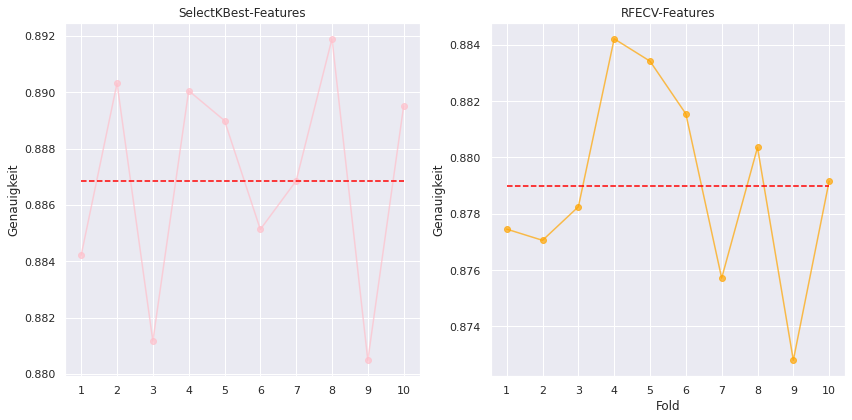

Mittlere Kreuzvalidierungs-Genauigkeit mit SelectKBest-Features: 0.8868625182648812
Mittlere Kreuzvalidierungs-Genauigkeit mit RFECV-Features: 0.8789972092070834


In [40]:
# Setzen Feature-Namen
selectkbest_features = selected_features  
selectrfecv_features = selected_features_rfecv 

# Modell erstellen
clf = lgb.LGBMClassifier(n_jobs=16, verbose=0, force_row_wise=True)

# Kreieren den StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=529)

# Kreuzvalidierung mit SelectKBest-Features
cv_scores_selectkbest = cross_val_score(clf, frame_train[selectkbest_features], y_train, cv=stratified_kfold)

# Kreuzvalidierung mit RFE-Features
cv_scores_rfecv = cross_val_score(clf, frame_train[selectrfecv_features], y_train, cv=stratified_kfold)

# Folds Nummerierung
folds = np.arange(1, 11)

# Erstelle eine Abbildung und Achsen für zwei Subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Erstes Liniendiagramm für SelectKBest-Features
axs[0].plot(folds, cv_scores_selectkbest, color='pink', alpha=0.7, marker='o')
axs[0].plot(folds, [cv_scores_selectkbest.mean()] * 10, linestyle='--', color='red')
axs[0].set_title('SelectKBest-Features')
axs[1].set_xlabel('Fold')
axs[0].set_ylabel('Genauigkeit')
axs[0].set_xticks(folds)

# Zweites Liniendiagramm für RFE-Features
axs[1].plot(folds, cv_scores_rfecv, color='orange', alpha=0.7, marker='o')
axs[1].plot(folds, [cv_scores_rfecv.mean()] * 10, linestyle='--', color='red')
axs[1].set_title('RFECV-Features')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('Genauigkeit')
axs[1].set_xticks(folds)

# Anzeigen der Abbildung
plt.tight_layout()
plt.show()

print(f'Mittlere Kreuzvalidierungs-Genauigkeit mit SelectKBest-Features: {np.mean(cv_scores_selectkbest)}')
print(f'Mittlere Kreuzvalidierungs-Genauigkeit mit RFECV-Features: {np.mean(cv_scores_rfecv)}')

Basierend auf den durchschnittlichen Ergebnissen der Kreuzvalidierungsgenauigkeit entscheiden wir uns dafür, die besten Merkmale aus der SelectKBest-Methode auszuwählen. Im direkten Vergleich erreicht SelectKBest eine Genauigkeit von etwa 88,63%, während RFECV rund 87,9% Genauigkeit erzielt. Mit hohen Genauigkeitswerten von SelectKbest Methoden stellen wir sicher, dass wir ein robustes Modell haben, das weniger anfällig für Overfitting ist.

### Trainieren des Modells auf den Trainingsdaten und Berechnung der Genauigkeit auf Trainings- und Validierungsdaten

Alle drei Modelle, die wir ausgewählt haben, sind Ensembled-Modelle, genauer gesagt gehören sie zu den Gradient Boosting Modellen.

Jedes dieser Modelle hat seine eigene Spezialisierung und Stärken:

- LightGBM ist für seine Effizienz und Geschwindigkeit bekannt. Es verwendet eine Technik, die als "Histogram-based Gradient Boosting" bezeichnet wird, welche den Speicherbedarf während des Trainings reduziert und die Geschwindigkeit des Algorithmus erhöht.

- XGBoost ist für seine Robustheit und Genauigkeit geschätzt. Es implementiert eine Vielzahl von Regularisierungstechniken, die Overfitting vermeiden und die allgemeine Leistung des Modells verbessern können.

- CatBoost ist besonders vorteilhaft, wenn der Datensatz viele kategoriale Merkmale enthält. Es verwendet eine spezielle Codierungstechnik für kategoriale Variablen, die die Vorhersageleistung verbessern kann.

Diese Modelle eignen sich sehr gut für Klassifikationsaufgabe. Allerdings kann der Einsatz mehr Rechenzeit und Speicher erfordern im Vergleich zu einfacheren Modellen.

### *Mit SelectKBest*

- ### LightGBM 

#### *Finden der besten Hyperparameter für LightGBM Modell mit RandomizedSearchCV*

In [43]:
# Parametergitter definieren
param_grid = {
    'num_leaves': [31, 64],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 60],
    'lambda_l1': [0, 1],
    'lambda_l2': [0, 1]
    }

# Randomized Search Objekt erstellen
random = RandomizedSearchCV(lgb.LGBMClassifier(n_jobs=16, verbose=0, force_row_wise=True), param_grid, verbose=1, cv=3, n_jobs=-1, n_iter=10)

# Modell trainieren
random.fit(frame_train[selectkbest_features].sample(frac=0.5, random_state=0), y_train.sample(frac=0.5, random_state=0))

# Beste Parameter anzeigen
print("Beste Parameter für LightGBM Modell: ", random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Beste Parameter für LightGBM Modell:  {'reg_alpha': 0.5, 'num_leaves': 64, 'min_data_in_leaf': 30, 'lambda_l2': 0, 'lambda_l1': 1}


#### *Traning mit besten Parameter auf Traningsdaten und Validierungsdaten*

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


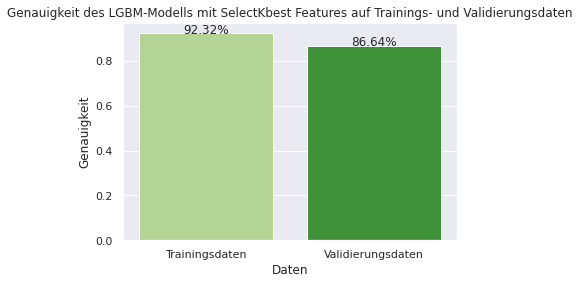

Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: 0.9231779295709265
Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: 0.8664479280593025


In [124]:
# Modell erstellen mit besten Hyperparametern
clf_lgbm = lgb.LGBMClassifier(n_jobs=16, verbose=0, force_row_wise=True, num_leaves=64, reg_alpha=0.5, min_data_in_leaf=30)

# Modell trainieren mit RFE-Features 
clf_lgbm.fit(frame_train[selectkbest_features], y_train)

# Vorhersagen und Genauigkeiten berechnen
y_pred_train_lgbm = clf_lgbm.predict(frame_train[selectkbest_features])
y_pred_val_lgbm = clf_lgbm.predict(frame_val[selectkbest_features])
accuracy_train_lgbm = accuracy_score(y_train, y_pred_train_lgbm)
accuracy_val_lgbm = accuracy_score(y_val, y_pred_val_lgbm)

colors = sns.color_palette("Paired", 20)[14:16]

def plot_accuracy(results, title):
    accuracy_data = pd.DataFrame.from_dict(results, orient='index', columns=['Genauigkeit'])
    ax = sns.barplot(x=accuracy_data.index, y=accuracy_data['Genauigkeit'], palette=colors)
    ax.set_xlabel('Daten')
    ax.set_ylabel('Genauigkeit')
    ax.set_title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(height*100),
                ha="center") 
    plt.show()


results = {'Trainingsdaten': accuracy_train_lgbm, 'Validierungsdaten': accuracy_val_lgbm}
plot_accuracy(results, 'Genauigkeit des LGBM-Modells mit SelectKbest Features auf Trainings- und Validierungsdaten')


print(f'Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: {accuracy_train_lgbm}')
print(f'Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: {accuracy_val_lgbm}')

- ### XGBoost

#### *Finden der besten Hyperparameter für XGBoost Modell mit RandomizedSearchCV*

In [50]:
# Parametergitter definieren
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5],
    'learning_rate': [0.01, 0.2],
    'gamma': [0.4, 0.5],
    'min_child_weight': [1, 3],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.4, 0.6],
    'reg_alpha': [0, 2],
    'reg_lambda': [4, 5]
    }

# Randomized Search Objekt erstellen
random = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=16), param_grid, verbose=1, cv=3, n_jobs=-1, n_iter=10)

# Modell trainieren
random.fit(frame_train[selectkbest_features].sample(frac=0.5, random_state=0), y_train.sample(frac=0.5, random_state=0))

# Beste Parameter anzeigen
print("Beste Parameter für XGBoost Modell: ", random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Parameter für XGBoost Modell:  {'subsample': 0.8, 'reg_lambda': 4, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6}


#### *Traning mit besten Parameter auf Traningsdaten und Validierungsdaten*

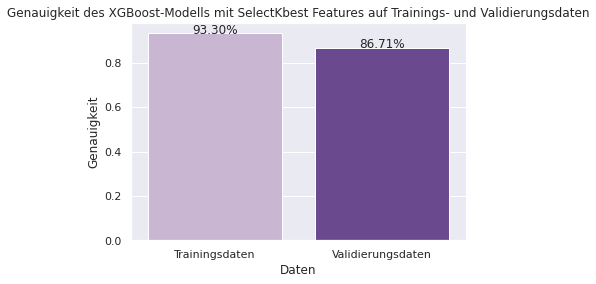

Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: 0.9330194309967504
Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: 0.8670555353019808


In [80]:
# Modell erstellen mit den besten Hyperparametern
clf_xgb = XGBClassifier(
    n_jobs=16, 
    verbosity=0, 
    use_label_encoder=False, 
    eval_metric='logloss',
    subsample=0.8, 
    reg_lambda=4,  
    reg_alpha=0, 
    n_estimators=300, 
    min_child_weight=3, 
    max_depth=5,  
    learning_rate=0.2, 
    gamma=0.5, 
    colsample_bytree=0.6
)

# Modell trainieren mit RFE-Features 
clf_xgb.fit(frame_train[selectkbest_features], y_train)

# Vorhersagen und Genauigkeiten berechnen
y_pred_train_xgb = clf_xgb.predict(frame_train[selectkbest_features])
y_pred_val_xgb = clf_xgb.predict(frame_val[selectkbest_features])
accuracy_train_xgb = accuracy_score(y_train, y_pred_train_xgb)
accuracy_val_xgb = accuracy_score(y_val, y_pred_val_xgb)

# Ergebnisse in ein Dictionary einfügen
results = {'Trainingsdaten': accuracy_train_xgb, 'Validierungsdaten': accuracy_val_xgb}
colors = sns.color_palette("Paired", 10)[8:10]
plot_accuracy(results, 'Genauigkeit des XGBoost-Modells mit SelectKbest Features auf Trainings- und Validierungsdaten')

print(f'Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: {accuracy_train_xgb}')
print(f'Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: {accuracy_val_xgb}')

- ### Catboost

#### *Finden der besten Hyperparameter für Catboost Modell mit RandomizedSearchCV*

In [81]:
# Parametergitter definieren
param_grid = {
    'depth': [5, 6],
    'learning_rate' : [0.01, 0.1],
    'l2_leaf_reg': [3, 5],
    'border_count': [100, 200]
}

# Randomized Search Objekt erstellen
random = RandomizedSearchCV(CatBoostClassifier(verbose=0), param_grid, verbose=1, cv=3, n_jobs=-1, n_iter=10)

# Modell trainieren
random.fit(frame_train[selectkbest_features].sample(frac=0.5, random_state=0), y_train.sample(frac=0.5, random_state=0))

# Beste Parameter anzeigen
print("Beste Parameter für Catboost: ", random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Parameter für Catboost:  {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'depth': 6, 'border_count': 200}


#### *Traning mit besten Parameter auf Traningsdaten und Validierungsdaten*

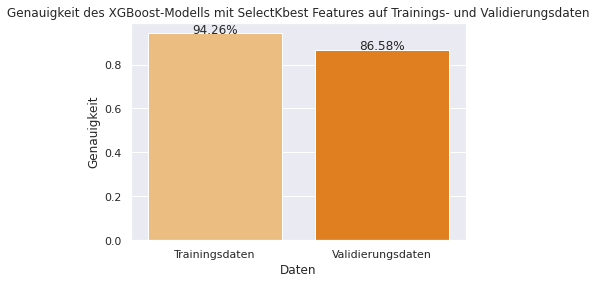

Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: 0.942608926321374
Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: 0.8658403208166241


In [109]:
# Modell erstellen mit den angepassten Hyperparametern
clf_catboost = CatBoostClassifier(
    learning_rate=0.1, 
    l2_leaf_reg=3,  # erhöhen der Regularisierung
    depth=6,  # reduzieren der Modellkomplexität
    border_count=200, 
    verbose=0
)

# Modell trainieren mit RFE-Features 
clf_catboost.fit(frame_train[selectkbest_features], y_train)

# Vorhersagen und Genauigkeiten berechnen
y_pred_train_catboost = clf_catboost.predict(frame_train[selectkbest_features])
y_pred_val_catboost = clf_catboost.predict(frame_val[selectkbest_features])
accuracy_train_catboost = accuracy_score(y_train, y_pred_train_catboost)
accuracy_val_catboost = accuracy_score(y_val, y_pred_val_catboost)

# Ergebnisse in ein Dictionary einfügen
results = {'Trainingsdaten': accuracy_train_catboost, 'Validierungsdaten': accuracy_val_catboost}
colors = sns.color_palette("Paired", 10)[6:8]
plot_accuracy(results, 'Genauigkeit des XGBoost-Modells mit SelectKbest Features auf Trainings- und Validierungsdaten')

print(f'Genauigkeit mit SelectKbest-Features auf den Trainingsdaten: {accuracy_train_catboost}')
print(f'Genauigkeit mit SelectKbest-Features auf den Validierungsdaten: {accuracy_val_catboost}')


### Vergleich der Ergbenisse von allen 3 Modellen

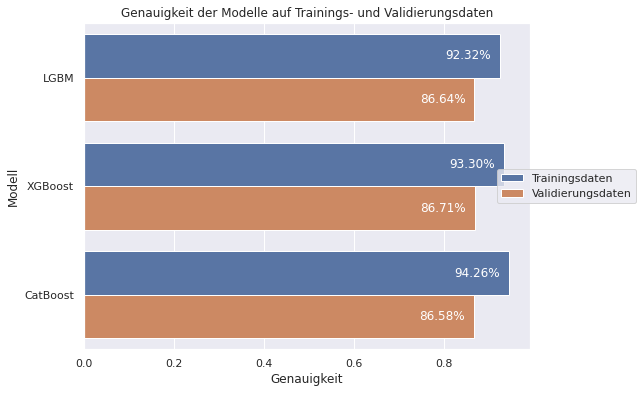

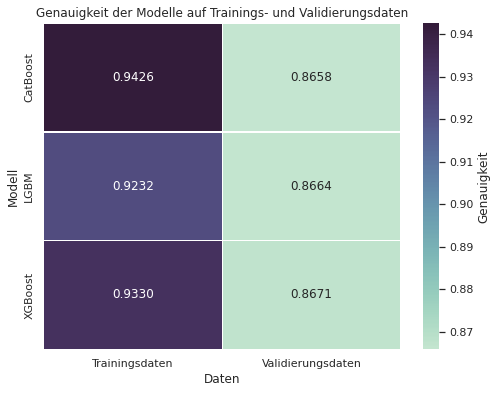

In [110]:
# die Genauigkeiten in Listen speichern
accuracy_train = [accuracy_train_lgbm, accuracy_train_xgb, accuracy_train_catboost]
accuracy_val = [accuracy_val_lgbm, accuracy_val_xgb, accuracy_val_catboost]

# DataFrame für die Ergebnisse erstellen
df_results = pd.DataFrame({'Modell': ['LGBM', 'XGBoost', 'CatBoost', 'LGBM', 'XGBoost', 'CatBoost'],
                           'Genauigkeit': accuracy_train + accuracy_val,
                           'Daten': ['Trainingsdaten']*3 + ['Validierungsdaten']*3})

palette = sns.color_palette("deep")

# Barplot erstellen
plt.figure(figsize=(8,6))
ax = sns.barplot(x='Genauigkeit', y='Modell', hue='Daten', data=df_results, palette=palette)

for p in ax.patches:
    width = p.get_width() 
    plt.text(width-0.02,     
             p.get_y() + p.get_height() / 2,
             '{:1.2f}%'.format(width*100),  
             color='white', 
             ha="right", 
             va="center")

plt.title('Genauigkeit der Modelle auf Trainings- und Validierungsdaten')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

# Daten vorbereiten
df_results_pivot = df_results.pivot('Modell', 'Daten', 'Genauigkeit')

# Heatmap erstellen
plt.figure(figsize=(8,6))
colors = sns.cubehelix_palette(start=.6, rot=-.6, as_cmap=True)
sns.heatmap(df_results_pivot, annot=True, fmt=".4f", linewidths=.5, cmap=colors, cbar_kws={'label': 'Genauigkeit'})
plt.title('Genauigkeit der Modelle auf Trainings- und Validierungsdaten')
plt.show()

**Aus den Ergebnissen können wir ableiten, dass CatBoost die höchste Genauigkeit sowohl auf den Trainings- als auch auf den Validierungsdaten aufweist. Die Genauigkeit auf den Trainingsdaten liegt über 90%. Allerdings zeigt CatBoost im Vergleich zu den anderen Modellen den größten Unterschied zwischen der Genauigkeit auf den Trainings- und den Validierungsdaten.**

**Das LGBM-Modell erreicht den zweiten Platz. Die Genauigkeit auf den Trainingsdaten beträgt 89,48%, während die Genauigkeit auf den Validierungsdaten bei etwa 86,51% liegt.**

**Das XGBoost-Modell belegt den letzten Platz. Interessanterweise ist die Genauigkeit auf den Validierungsdaten etwas höher als die Genauigkeit auf den Trainingsdaten. Die Genauigkeit auf den Trainingsdaten beträgt 84,77%, während die Genauigkeit auf den Validierungsdaten 84,86% beträgt.**

**Diese Ergebnisse zeigen, dass trotz geringfügiger Unterschiede in der Leistung alle drei Modelle eine hohe Genauigkeit aufweisen und für diese Art von Klassifizierungsaufgaben gut geeignet sind. Es wäre auch interessant, andere Metriken wie Präzision, Recall oder den F1-Score zu betrachten, um ein vollständigeres Bild der Leistung dieser Modelle zu erhalten.**

### Präzision, Recall, F1-Score, ROC-Kurve auf Validierungsdaten

- ### LightGBM 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6528
           1       0.73      0.57      0.64      1701

    accuracy                           0.87      8229
   macro avg       0.81      0.76      0.78      8229
weighted avg       0.86      0.87      0.86      8229



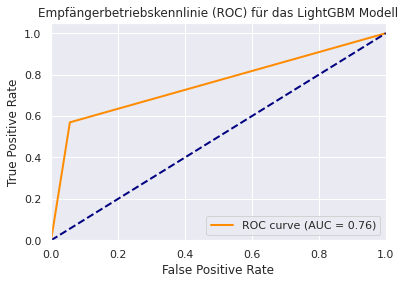

In [111]:
# Präzision, Recall, F1-Score berechnen

print(classification_report(y_val, y_pred_val_lgbm))

# ROC-Kurve und AUC berechnen
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_lgbm)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Empfängerbetriebskennlinie (ROC) für das LightGBM Modell')
plt.legend(loc="lower right")
plt.show()

- ### XGBoost

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6528
           1       0.71      0.60      0.65      1701

    accuracy                           0.87      8229
   macro avg       0.81      0.77      0.78      8229
weighted avg       0.86      0.87      0.86      8229



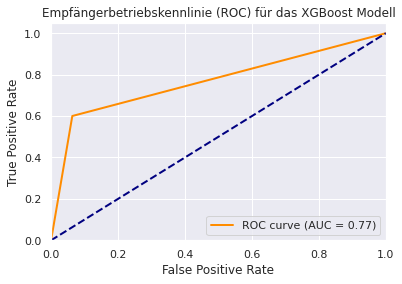

In [112]:
# Präzision, Recall, F1-Score berechnen

print(classification_report(y_val, y_pred_val_xgb))

# ROC-Kurve und AUC berechnen
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Empfängerbetriebskennlinie (ROC) für das XGBoost Modell')
plt.legend(loc="lower right")
plt.show()

- ### Catboost

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      6528
           1       0.71      0.60      0.65      1701

    accuracy                           0.87      8229
   macro avg       0.80      0.77      0.78      8229
weighted avg       0.86      0.87      0.86      8229



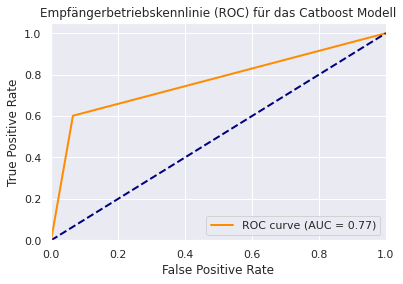

In [113]:
# Präzision, Recall, F1-Score berechnen

print(classification_report(y_val, y_pred_val_catboost))

# ROC-Kurve und AUC berechnen
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_catboost)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Empfängerbetriebskennlinie (ROC) für das Catboost Modell')
plt.legend(loc="lower right")
plt.show()

- ### Interpretation der Ergebnisse

**1. LightGBM:**
Das LightGBM-Modell zeigt gute Leistung mit einer Genauigkeit von 87%. Die Precision für die Klasse 0 (warten) ist sehr hoch (0.89), was darauf hindeutet, dass das Modell sehr gut darin ist, tatsächliche negative Instanzen zu identifizieren. Der Recall für die Klasse 0 ist ebenfalls hoch (0.95), was zeigt, dass das Modell fast alle negativen Instanzen erfasst hat. Allerdings sind die Precision und der Recall für die Klasse 1 (kaufen) niedriger als Klasse 0.

**2. XGBoost:**
Das XGBoost-Modell hat eine Genauigkeit von 85%. Die Precision für die Klasse 0 ist etwas niedriger als beim LightGBM, während der Recall deutlich höher ist. Dies deutet darauf hin, dass das XGBoost-Modell dazu neigt, mehr Instanzen als Klasse 0 zu klassifizieren, was zu einer höheren Anzahl von falsch positiven Vorhersagen führen kann. Wie bei LightGBM sind die Precision und der Recall für die Klasse 1 niedriger.

**3. CatBoost:**
Das CatBoost-Modell zeigt eine ähnliche Leistung wie das LightGBM mit einer Genauigkeit von 87%. Es hat eine etwas höhere Precision für die Klasse 0 und einen etwas niedrigeren Recall im Vergleich zu LightGBM. Bei der Klasse 1 hat CatBoost jedoch eine etwas höhere Precision und einen deutlich höheren Recall, was darauf hindeutet, dass es besser darin ist, positive Instanzen zu identifizieren und korrekt vorherzusagen.

Zusammengefasst scheint das CatBoost-Modell insgesamt eine leicht bessere Leistung zu erzielen, insbesondere bei der Klassifikation von positiven Instanzen (Klasse 1). Die relativ geringere Leistung bei der Identifizierung der Klasse 1 könnte auf ein Ungleichgewicht in den Klassen innerhalb der Daten hinweisen. Wie wir zu Beginn erwähnt haben, ist unser Datensatz unausgeglichen - wir haben 64.906 Instanzen der Klasse "warten" und nur 18.718 Instanzen der Klasse "kaufen".

## Vorhersage des Testdatensatzes

### LightGBM 

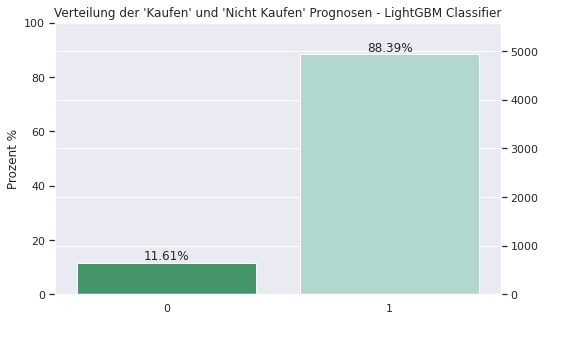

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,season,Request_Dayofweek,Request_month,days_diff_Req_Flight,Flight_Dayofweek,Flight_month,Flight_weekofyear,weekend,departure_time,Request_time,source,destination,buy_lgbm,buy_xgb,buy_cat,buy
0,1,0,2019-06-05,7,2019-07-02 FR 145,STN-SXF,30.32,spring,0,6,1,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
1,2,2,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.53,spring,1,6,1,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
2,3,4,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.47,spring,1,6,0,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
3,4,6,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.47,spring,2,6,0,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
4,5,8,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.52,spring,2,6,-1,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
5,6,10,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.20,spring,3,6,-1,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
6,7,12,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.23,spring,3,6,-2,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
7,8,14,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.23,spring,4,6,-2,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
8,9,18,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.50,spring,5,6,-3,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
9,10,20,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.50,spring,5,6,-4,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True


In [114]:
# Vorhersagen für Testdaten machen
pred_test_lgbm = clf_lgbm.predict(frame_test[selectkbest_features])
pred_prob_lgbm = clf_lgbm.predict_proba(frame_test[selectkbest_features])[:,1]

# Die Vorhersagen in der DataFrame speichern
flug_df_test['buy_lgbm'] = pred_test_lgbm

# Funktion für die Visualisierung
def visualization(column, title):
    ncount = len(flug_df_test)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Prozent %')
    plt.title(title)

    for i in ax.patches:
        x=i.get_bbox().get_points()[:,0]
        y=i.get_bbox().get_points()[1,1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

ax = sns.countplot(x=flug_df_test['buy_lgbm'], palette="BuGn_r")
sns.set(font_scale=1.)
ax.set_ylim(top=len(flug_df_test))
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,5)

visualization('buy_lgbm', "Verteilung der 'Kaufen' und 'Nicht Kaufen' Prognosen - LightGBM Classifier")

plt.show()

# Erste 10 Zeilen anzeigen
flug_df_test.head(10)

### XGBoost

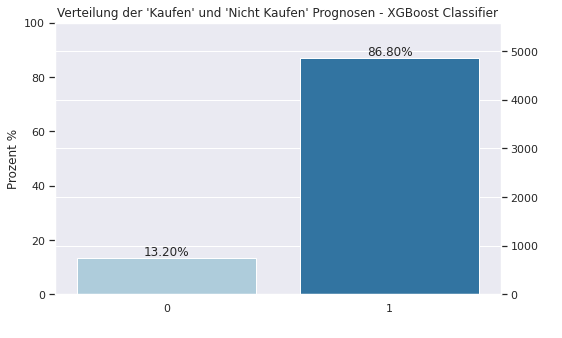

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,season,Request_Dayofweek,Request_month,days_diff_Req_Flight,Flight_Dayofweek,Flight_month,Flight_weekofyear,weekend,departure_time,Request_time,source,destination,buy_lgbm,buy_xgb,buy_cat,buy
0,1,0,2019-06-05,7,2019-07-02 FR 145,STN-SXF,30.32,spring,0,6,1,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
1,2,2,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.53,spring,1,6,1,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
2,3,4,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.47,spring,1,6,0,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
3,4,6,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.47,spring,2,6,0,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
4,5,8,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.52,spring,2,6,-1,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
5,6,10,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.20,spring,3,6,-1,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
6,7,12,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.23,spring,3,6,-2,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
7,8,14,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.23,spring,4,6,-2,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
8,9,18,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.50,spring,5,6,-3,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
9,10,20,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.50,spring,5,6,-4,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True


In [115]:
# Vorhersagen für Testdaten machen
pred_test_xgb = clf_xgb.predict(frame_test[selectkbest_features])
pred_prob_xgb = clf_xgb.predict_proba(frame_test[selectkbest_features])[:,1]

# Die Vorhersagen in der DataFrame speichern
flug_df_test['buy_xgb'] = pred_test_xgb

ax = sns.countplot(x=flug_df_test['buy_xgb'], palette="Paired")
sns.set(font_scale=1.)
ax.set_ylim(top=len(flug_df_test))
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,5)

visualization('buy_xgb', "Verteilung der 'Kaufen' und 'Nicht Kaufen' Prognosen - XGBoost Classifier")

plt.show()

# Erste 10 Zeilen anzeigen
flug_df_test.head(10)

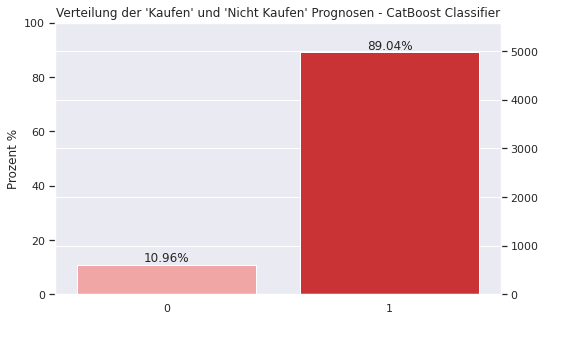

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,season,Request_Dayofweek,Request_month,days_diff_Req_Flight,Flight_Dayofweek,Flight_month,Flight_weekofyear,weekend,departure_time,Request_time,source,destination,buy_lgbm,buy_xgb,buy_cat,buy
0,1,0,2019-06-05,7,2019-07-02 FR 145,STN-SXF,30.32,spring,0,6,1,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
1,2,2,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.53,spring,1,6,1,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
2,3,4,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.47,spring,1,6,0,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
3,4,6,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.47,spring,2,6,0,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
4,5,8,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.52,spring,2,6,-1,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
5,6,10,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.20,spring,3,6,-1,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
6,7,12,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.23,spring,3,6,-2,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True
7,8,14,2019-06-05,7,2019-07-02 FR 145,STN-SXF,35.23,spring,4,6,-2,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
8,9,18,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.50,spring,5,6,-3,2,6,23,0,Early Morning,Late Night,London,Berlin,1,1,1,True
9,10,20,2019-06-05,7,2019-07-02 FR 145,STN-SXF,44.50,spring,5,6,-4,2,6,23,0,Early Morning,Afternoon,London,Berlin,1,1,1,True


In [116]:
# Vorhersagen für Testdaten machen
pred_test_cat = clf_catboost.predict(frame_test[selectkbest_features])
pred_prob_cat = clf_catboost.predict_proba(frame_test[selectkbest_features])[:,1]

# Die Vorhersagen in der DataFrame speichern
flug_df_test['buy_cat'] = pred_test_cat

colors = sns.color_palette("Paired")[4:6]
ax = sns.countplot(x=flug_df_test['buy_cat'], palette= colors)
sns.set(font_scale=1.)
ax.set_ylim(top=len(flug_df_test))
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,5)

visualization('buy_cat', "Verteilung der 'Kaufen' und 'Nicht Kaufen' Prognosen - CatBoost Classifier")

plt.show()

# Erste 10 Zeilen anzeigen
flug_df_test.head(10)

### Vergleich der Ergebnisse von 3 Modellen

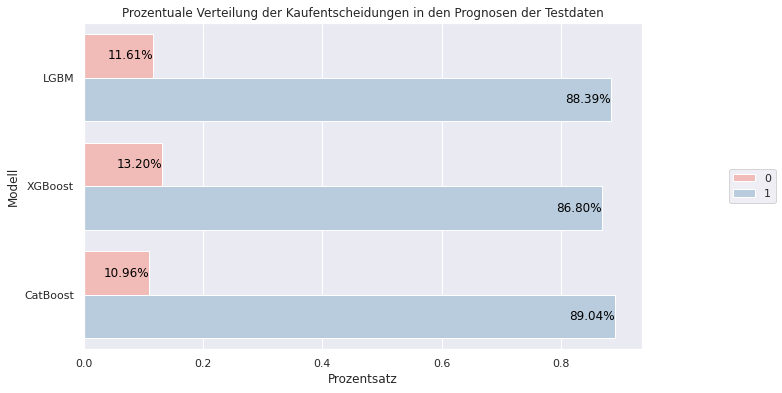

In [117]:
# "buy"-Werte zählen für jedes Modell
counts_lgbm = flug_df_test['buy_lgbm'].value_counts(normalize=True)
counts_xgb = flug_df_test['buy_xgb'].value_counts(normalize=True)
counts_cat = flug_df_test['buy_cat'].value_counts(normalize=True)

# DataFrame für die Ergebnisse erstellen
df_results_test = pd.DataFrame({
    'Modell': ['LGBM']*len(counts_lgbm) + ['XGBoost']*len(counts_xgb) + ['CatBoost']*len(counts_cat),
    'Kaufentscheidung': list(counts_lgbm.index) + list(counts_xgb.index) + list(counts_cat.index),
    'Prozentsatz': list(counts_lgbm.values) + list(counts_xgb.values) + list(counts_cat.values)
})

palette = sns.color_palette("Pastel1", df_results_test['Modell'].nunique())

# Barplot erstellen
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Prozentsatz', y='Modell', hue='Kaufentscheidung', data=df_results_test, palette=palette)

for p in ax.patches:
    width = p.get_width() 
    plt.text(width,     
             p.get_y() + p.get_height() / 2,
             '{:1.2f}%'.format(width*100),  
             color='black', 
             ha="right", 
             va="center")

plt.title('Prozentuale Verteilung der Kaufentscheidungen in den Prognosen der Testdaten')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()


## Berechnung des monetären Maßes 

- ### Evaluation Function

In [118]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                 bool


def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price_In_Eur'] = df['Price_In_Eur'] * 100
    df['Price_In_Eur'] = df['Price_In_Eur'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        #request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)
        request_dates = request_dates.sort_values(by='Request_Date', ascending=False)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price_In_Eur'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price_In_Eur']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price_In_Eur']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100
    

- ### LightGBM

In [125]:
# Datentypen konvertieren
flug_df_test['Request_Date']= flug_df_test['Request_Date'].astype('category').cat.codes
flug_df_test['buy'] = flug_df_test['buy_lgbm'].astype(bool)

# DataFrame nur mit den benötigten Spalten für die Vorhersagen erstellen
predictions_df = flug_df_test[['Request_Date','flight_unique_id','Price_In_Eur','buy']]

#  # Test the evaluation function on the example provided by Prof. Spott:
for i in predictions_df['flight_unique_id'].unique():
    example_data = predictions_df[predictions_df['flight_unique_id'] == i]
    print(f"{i}: {model_quality_evaluation(example_data)}")

 # Test the evaluation function on the whole dataframe (2 flights):
print(f"Gesamtwert bei LightGBM Modell: {model_quality_evaluation(predictions_df)}")

2019-07-02 FR 145: 0.0
2019-07-02 FR 1546: 0.0
2019-07-03 FR 8545: 0.0
2019-07-04 FR 8544: 0.0
2019-07-05 FR 8542: -0.1
2019-07-05 FR 8544: -48.53
2019-07-07 FR 1687: 118.38
2019-07-07 FR 8543: -20.4
2019-07-08 FR 8543: 0.0
2019-07-08 FR 8544: 57.11
2019-07-09 FR 147: 57.87
2019-07-09 FR 8545: 0.0
2019-07-10 FR 8544: -94.18
2019-07-10 FR 147: 34.12
2019-07-11 FR 8545: 0.0
2019-07-12 FR 1547: -34.8
2019-07-13 FR 1686: 0.0
2019-07-13 FR 145: 108.38
2019-07-13 FR 8543: 0.0
2019-07-13 FR 8544: 2.89
2019-07-13 FR 1547: 200.43
2019-07-14 FR 144: 19.8
2019-07-14 FR 8542: 58.16
2019-07-15 FR 1687: 24.62
2019-07-15 FR 145: 100.66
2019-07-16 FR 1686: 0.0
2019-07-16 FR 8542: 83.3
2019-07-16 FR 145: 180.28
2019-07-16 FR 1547: -30.35
2019-07-17 FR 145: 19.74
2019-07-17 FR 1547: 19.58
2019-07-19 FR 144: 0.0
2019-07-19 FR 1546: 58.14
2019-07-19 FR 8544: 183.97
2019-07-20 FR 8542: 122.74
2019-07-20 FR 1687: 270.66
2019-07-21 FR 1686: 134.55
2019-07-21 FR 145: 486.22
2019-07-21 FR 146: 470.22
2019-07-2

- ### XGBoost

In [120]:
# Datentypen konvertieren
flug_df_test['Request_Date']= flug_df_test['Request_Date'].astype('category').cat.codes
flug_df_test['buy'] = flug_df_test['buy_xgb'].astype(bool)

# DataFrame nur mit den benötigten Spalten für die Vorhersagen erstellen
predictions_df = flug_df_test[['Request_Date','flight_unique_id','Price_In_Eur','buy']]

#  # Test the evaluation function on the example provided by Prof. Spott:
for i in predictions_df['flight_unique_id'].unique():
    example_data = predictions_df[predictions_df['flight_unique_id'] == i]
    print(f"{i}: {model_quality_evaluation(example_data)}")

 # Test the evaluation function on the whole dataframe (2 flights):
print(f"Gesamtwert bei XGBoost Modell: {model_quality_evaluation(predictions_df)}")

2019-07-02 FR 145: 0.0
2019-07-02 FR 1546: 0.0
2019-07-03 FR 8545: 0.0
2019-07-04 FR 8544: -14.07
2019-07-05 FR 8542: -61.9
2019-07-05 FR 8544: 0.1
2019-07-07 FR 1687: 118.38
2019-07-07 FR 8543: -20.4
2019-07-08 FR 8543: 0.0
2019-07-08 FR 8544: 57.11
2019-07-09 FR 147: 57.87
2019-07-09 FR 8545: 0.0
2019-07-10 FR 8544: -93.72
2019-07-10 FR 147: 34.12
2019-07-11 FR 8545: 98.85
2019-07-12 FR 1547: -34.8
2019-07-13 FR 1686: 113.25
2019-07-13 FR 145: 108.38
2019-07-13 FR 8543: 0.0
2019-07-13 FR 8544: 43.57
2019-07-13 FR 1547: 218.39
2019-07-14 FR 144: 0.0
2019-07-14 FR 8542: 39.16
2019-07-15 FR 1687: 24.4
2019-07-15 FR 145: 114.47
2019-07-16 FR 1686: 0.0
2019-07-16 FR 8542: 83.3
2019-07-16 FR 145: 175.22
2019-07-16 FR 1547: 7.96
2019-07-17 FR 145: 899.12
2019-07-17 FR 1547: 32.68
2019-07-19 FR 144: 17.32
2019-07-19 FR 1546: 58.14
2019-07-19 FR 8544: 182.17
2019-07-20 FR 8542: 180.9
2019-07-20 FR 1687: 270.24
2019-07-21 FR 1686: 272.47
2019-07-21 FR 145: 486.08
2019-07-21 FR 146: 680.34
2019

- ### Catboost

In [121]:
# Datentypen konvertieren
flug_df_test['Request_Date']= flug_df_test['Request_Date'].astype('category').cat.codes
flug_df_test['buy'] = flug_df_test['buy_cat'].astype(bool)

# DataFrame nur mit den benötigten Spalten für die Vorhersagen erstellen
predictions_df = flug_df_test[['Request_Date','flight_unique_id','Price_In_Eur','buy']]

#  # Test the evaluation function on the example provided by Prof. Spott:
for i in predictions_df['flight_unique_id'].unique():
    example_data = predictions_df[predictions_df['flight_unique_id'] == i]
    print(f"{i}: {model_quality_evaluation(example_data)}")

 # Test the evaluation function on the whole dataframe (2 flights):
print(f"Gesamtwert bei Catboost Modell: {model_quality_evaluation(predictions_df)}")

2019-07-02 FR 145: 0.0
2019-07-02 FR 1546: 0.0
2019-07-03 FR 8545: 0.0
2019-07-04 FR 8544: 0.0
2019-07-05 FR 8542: 27.34
2019-07-05 FR 8544: 0.1
2019-07-07 FR 1687: 130.32
2019-07-07 FR 8543: 81.6
2019-07-08 FR 8543: 0.0
2019-07-08 FR 8544: 56.33
2019-07-09 FR 147: 57.87
2019-07-09 FR 8545: 0.0
2019-07-10 FR 8544: 306.39
2019-07-10 FR 147: 0.0
2019-07-11 FR 8545: 198.81
2019-07-12 FR 1547: 0.3
2019-07-13 FR 1686: 168.33
2019-07-13 FR 145: 452.16
2019-07-13 FR 8543: 99.96
2019-07-13 FR 8544: 2.0
2019-07-13 FR 1547: 134.16
2019-07-14 FR 144: 0.0
2019-07-14 FR 8542: 297.11
2019-07-15 FR 1687: 0.14
2019-07-15 FR 145: 120.64
2019-07-16 FR 1686: 0.0
2019-07-16 FR 8542: 181.75
2019-07-16 FR 145: 335.57
2019-07-16 FR 1547: 0.0
2019-07-17 FR 145: 1014.24
2019-07-17 FR 1547: 0.0
2019-07-19 FR 144: 0.0
2019-07-19 FR 1546: 52.02
2019-07-19 FR 8544: 274.06
2019-07-20 FR 8542: 368.59
2019-07-20 FR 1687: 254.7
2019-07-21 FR 1686: 41.4
2019-07-21 FR 145: 487.91
2019-07-21 FR 146: 706.86
2019-07-21 FR 

- ### Interpretation der Ergebnisse

Das **CatBoost-Modell** scheint das effektivste Modell zu sein, da es den höchsten Gesamtwert von 7652.26 Euro erreicht. Dies deutet darauf hin, dass dieses Modell im Durchschnitt die besten Kaufentscheidungen trifft, um die Kosten für Flugtickets zu minimieren.

Das **LightGBM-Modell** hat einen Gesamtwert von 5236.3 Euro. Obwohl es besser abschneidet als das XGBoost-Modell, liegt es dennoch hinter dem CatBoost-Modell. Dies könnte darauf hindeuten, dass es zwar gute Kaufentscheidungen trifft, aber nicht ganz so effektiv wie das CatBoost-Modell ist.

Das **XGBoost-Modell** hat den niedrigsten Gesamtwert von 3410.6 Euro. Dies bedeutet, dass es im Vergleich zu den anderen beiden Modellen weniger effektiv bei der Minimierung der Ticketkosten ist.

## Ausblick

Abschließend lässt sich feststellen, dass alle drei Modelle (LightGBM, XGBoost und CatBoost) eine angemessene Leistung bei der Vorhersage von Kaufentscheidungen auf der Grundlage des gegebenen Flugpreisdatensatzes gezeigt haben. In Anbetracht der Genauigkeit und der finanziellen Auswertungen war das CatBoost-Modell das effektivste, da es die höchste Genauigkeit und den höchsten finanziellen Gesamtwert erzielte. Es bietet eine gute Balance zwischen Genauigkeit und finanziellem Nutzen, indem es zuverlässige Kaufempfehlungen gibt und gleichzeitig die Kosten für den Ticketkauf minimiert.

Das LightGBM und XGBoost Modell zeigten jedoch auch eine respektable Leistung und könnten in anderen Szenarien oder bei Verwendung verschiedener Hyperparameter noch besser abschneiden.

Trotzdem sollten wir beachten, dass die Modelle Schwierigkeiten hatten, die Klasse "kaufen" genauso gut vorherzusagen wie die Klasse "warten", was wahrscheinlich auf ein Ungleichgewicht in den Datenklassen zurückzuführen ist. 

Diese Modelle können als effektive Werkzeuge dienen, um Benutzern zu helfen, fundierte Kaufentscheidungen zu treffen und Kosten zu sparen. Dennoch gibt es Raum für Verbesserungen und Erweiterungen, um die Genauigkeit und Effektivität dieser Modelle weiter zu steigern. Insbesondere könnten zukünftige Arbeiten zusätzliche Datenquellen, fortschrittlichere Modellierungstechniken oder umfassendere Feature-Engineering-Ansätze in Betracht ziehen.

Insgesamt zeigt dieses Projekt, dass Maschinelles Lernen und künstliche Intelligenz bei der Preisvorhersage und Entscheidungsfindung im Kontext des Ticketkaufs eine wertvolle Hilfe sein können. Es bietet sowohl für Verbraucher als auch für Unternehmen wertvolle Einblicke und kann zu Kosteneinsparungen und verbesserten Geschäftsentscheidungen führen.